In [14]:
# load libraries
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import wrds
import pandas_datareader.data as web

In [15]:
# define functions  
def get_daily_wrds(conn,tickers=None):
  
    # Retrieve PERMNOs for the specified tickers
    permnos = conn.get_table(library='crsp', table='stocknames', columns=['permno', 'ticker', 'namedt', 'nameenddt'])
    permnos['nameenddt']=pd.to_datetime(permnos['nameenddt'])
    permnos = permnos[(permnos['ticker'].isin(tickers)) & (permnos['nameenddt']==permnos['nameenddt'].max())]
    # Extract unique PERMNOs
    permno_list = permnos['permno'].unique().tolist()
    print(permno_list)

    # Query daily stock file for the specified PERMNOs
    
    query = f"""
        SELECT permno, date, ret, retx, prc       
        FROM crsp.dsf
        WHERE permno IN ({','.join(map(str, permno_list))})
        ORDER BY date,permno
    """
    daily_returns = conn.raw_sql(query, date_cols=['date'])
    daily_returns = daily_returns.merge(permnos[['permno', 'ticker']], on='permno', how='left')
# Pivot data to have dates as index and tickers as columns
    daily_returns = daily_returns.pivot(index='date', columns='ticker', values='ret').dropna()    
    daily_returns=daily_returns[tickers]

    return daily_returns


def get_factors(ff6=False):
    
    fama_french = web.DataReader("F-F_Research_Data_5_Factors_2x3_daily", "famafrench",start="1926-01-01")
    daily_data = fama_french[0]  # The first DataFrame contains the daily data
    daily_data.index = pd.to_datetime(daily_data.index)  # Ensure index is datetime
    if ff6==False:
        df_factor = daily_data[['RF','Mkt-RF']]  # Extract the Risk-Free Rate (RF)
    else:
        df_factor = daily_data[['RF','Mkt-RF','SMB','HML','RMW','CMA']]
        fama_french = web.DataReader("F-F_Momentum_Factor_daily", "famafrench",start="1926-01-01")
        df_factor=df_factor.merge(fama_french[0],on='Date')
    
    return df_factor/100

# Introduction to Factor models 



- Key idea is that stocks might have different degree of co-movement
- For example, Defensive stocks like utilities, supermarkets, and so on might not suffer as much as in recessions
- Small stocks, stocks with high leverage and so one might particularly suffer during economic busts


Let $r^e$ be an asset excess return over the risk-free rate

Let $f$ be a traded factor, for now  the excess returns on SPY ETF

Then we can write

$$r^e=\alpha + b*f+\epsilon$$

$$(excess~return)=(intercept)+(stock~beta)*(factor~excess~return)+ (idio~risk)$$

where $b$ is asset $i$ exposure to the factor $f$

We can always write things that way--it is just a statistical decomposition

1. It can be useful for measuring risk if
    - The risk $\epsilon$ is specific to asset $i$ and uncorrelated with other assets
    - I.e the factors picks up lots of the variation in stock returns 

2. It can be useful for measuring expected returns if
    - The premium on the factor f, $E[f]$ summarize well the known "priced" systematic risk factors
    - By "priced" we mean risk-factors that earn a risk premium  $E[f]>0$

We will call the first a factor model of risk, and the second a factor model of expected returns


What use is a factor model?

- the alpha/Beta decomposition is how the money management industry is organized. 
    - Big pay days only if people think you have alpha
    - Getting exposure to the factor is a commodity. Anyone can buy SPY or many other funds that track the market very well
    - In most funds, specially for portfolio managers working a pod shops like Citadel and Millenium, a portfolio manager mandate is to take no factor risk--or at least aim to be close to factor neutral.
    - It is all about the alpha 
- factor models allow you to understand and hedge risk
    - This is essential if you want to concentrate your portfolio only on the pieces that you get compensated






Lets go back to our example

In [ ]:
# load the data of the previous notebook
#conn = wrds.Connection()
df=get_daily_wrds_multiple_ticker(['SPY','WMT','JPM'],conn)
#Why did I divide by 252?
df=df.merge(df_rf/252, left_index=True, right_index=True,how='left')
df_re=df.drop(columns='rf').sub(df['rf'],axis=0)
df_re


beta of asset WMT is 0.6749692108883036
the "intercept" of asset WMT is 0.04522121157501705 annualized
beta of asset JPM is 1.374860222270463
the "intercept" of asset JPM is 0.023283503662360792 annualized


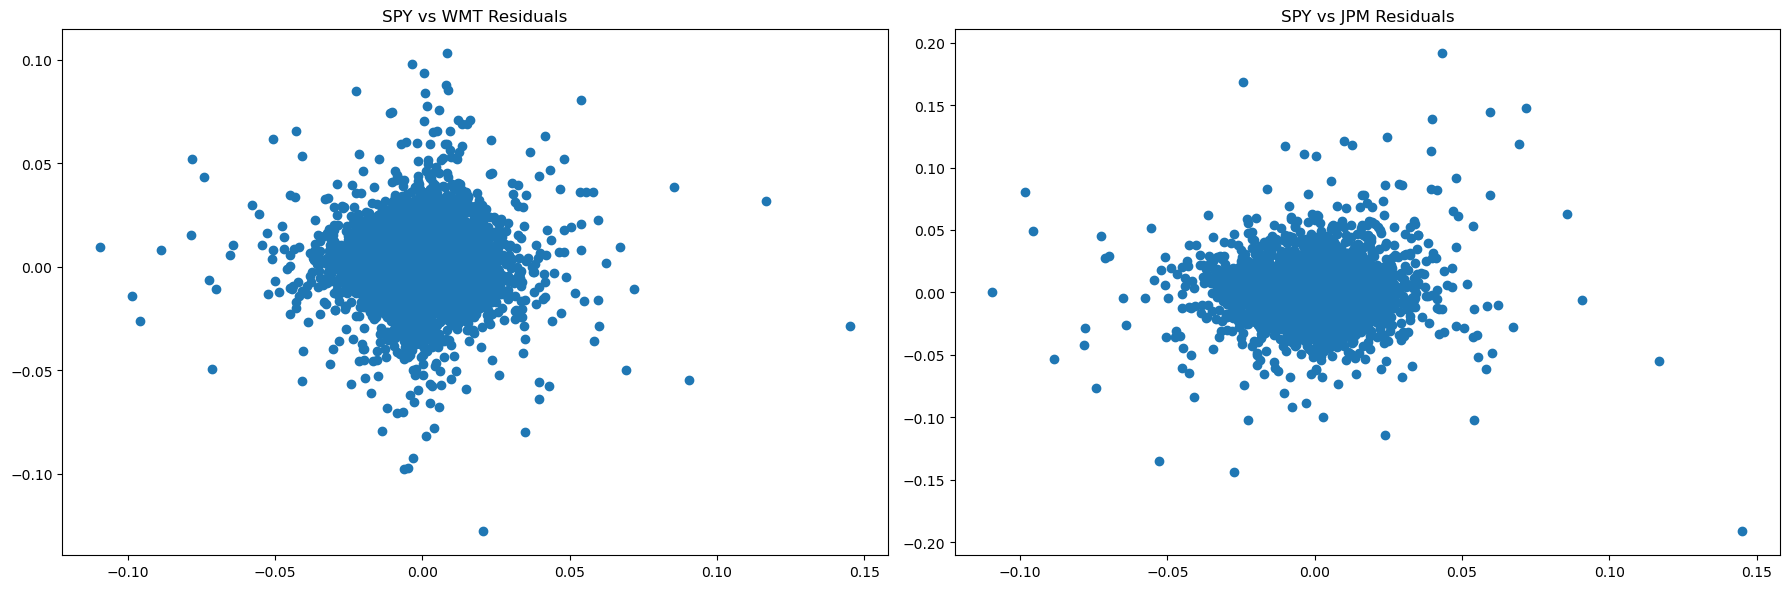

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18,6))
import statsmodels.api as sm

factor='SPY'
asset='WMT'    
X = sm.add_constant(df_re[factor])
model = sm.OLS(df_re[asset], X).fit()
intercept_wmt, beta_wmt = model.params
print(f'beta of asset {asset} is {beta_wmt}')


axes[0].scatter(x=df_re['SPY'], y=(df_re['WMT']-beta_wmt*df_re['SPY']))
axes[0].set_title('SPY vs WMT Residuals')

factor='SPY'
asset='JPM'    
X = sm.add_constant(df_re[factor])
model = sm.OLS(df_re[asset], X).fit()
intercept_jpm, beta_jpm = model.params
print(f'beta of asset {asset} is {beta_jpm}')


axes[1].scatter(x=df_re['SPY'], y=df_re['JPM']-beta_jpm*df_re['SPY'])
axes[1].set_title('SPY vs JPM Residuals')

plt.tight_layout()
plt.show()


Did it work?

- With the regression we have a statistical decomposition
- At least in sample, the regression guarantees that the stock specific component is completely orthogonal to the factor

$$stock~specific~component=(excess~return)-(stock~beta)*(factor~excess~return)$$

In [ ]:
df_re[['SPY']].corrwith(df_re['JPM']-beta_jpm*df_re['SPY'])



ticker
SPY    1.656269e-16
dtype: float64

In [ ]:
df_re[['SPY']].corrwith(df_re['WMT']-beta_wmt*df_re['SPY'])

ticker
SPY    5.141267e-17
dtype: float64


- $\beta$ , that is beta, measures factor exposure and together with the factor variance, it tells us the amount of factor risk in the asset
- $\epsilon$ is the idiossyncratic, non-factor risk component of the asset--all the risk that is leftover after we take out the co-movement with the factor
- intercept is going to be very important
- We will discuss this later in detail 

How do we estimate the amount of idiossyncratic risk?

How do we estimate the amount of systematic risk?



the historical variance of asset JPM idio risk is 0.06755883655421582 annualized
the historical standard deviation of asset JPM idio risk is 0.25992082747293616 annualized
the historical variance of the market factor is 0.035166377478007854 annualized
the historical standard deviation of the market factor is 0.18752700466334934 annualized


What is the variance of JPM that is due to "systematic" risk?

What is the calculation?

## Alpha and Beta(s)

Note that

$$E[r]=E[rf+r^{e}]=rf+E[\alpha_i + b*f+\epsilon]$$

$$E[r]=rf+\alpha+b*E[f]+E[\epsilon]$$

- Using that $E[\epsilon]=0$ we have
$$E[r]=rf+\alpha+b*E[f]$$

- Thus, just like the risk of our asset could be attributed to the factor and it's component, the same model also allow us to decompose the expected return in terms of the risk-free rate, the premium coming from the common factor exposure $b*E[f]$ and the risk-premium specific to the asset, the ALPHA.

- The alpha does not need to be in a specific asset, can be o a combination of them

- The decomposition works the same for portfolio of assets

- For now we have a single factor, but you will see that as you have more factors, everything will be very similar

What is the alpha of a 50-50 portfolio of JPM and WMT?

What is the beta of such portfolio?

What is the indio risk?

## Focus on your skill, hedge all the residual risk

No matter who you are, you will face dollar risk limits--or be naturally risk-averse

So it is essential that you deploy risk wisely

The key use of the factor model is to give you discipline to separate your edge from the rest

How to use the factor model?

First , realize that each piece of the factor model will require very thoughtful estimation

Even here with only one asset and one factor we already have to know many things

1. The risk-free rate
2. The beta 
3. The factor risk-premia
4. The factor variance
5. The asset specific alpha
6. The factor specific variance
   



## An example

For now we will assume we know each of these.

if you have an asset that has alpha, says, you are confident that APPLE will beat expectations and you expect a 5% appreciation in the next 12 months beyond any factor exposure that APPLE might had, what do you do?

1. Buy apple! 

But what is the market crashes? Why bear that risk?  
Portfolio allocators look for managers with alpha, not beta. 
What if the market crashes before apple surprises and your investors pull out?


2. Hedge the market
   - How do you do that?
   - Short it!
   - How much?
   - the asset beta!


Example:

1. You buy 1M in Apple stock, so your portfolio PnL is 1M*$r^{apple}$
2. Your portfolio PnL in excess what you would earn in treasuries is 1M*$(r^{apple}-rf)$
3. Sell (short) 1M*$\beta_{apple,f}$ of the factor
4. Now your portfolio is PnL above the risk-free rate is

$$1M*(r^{apple}-rf-\beta*r^{SPY}+\beta*rf)$$

When you sell SPY short you get the money and here I am "investing" it in the risk-free rate

Alternatively you can think of it as using to fund the apple buy

it does not matter, because we are accounting for the time-value of money

We certainly don't want to invest anything else to just add noise to our trade 


$$1M*(r^{apple}-\beta*r^{SPY}-(1-\beta)*rf)$$

For a high beta stock your trade generates extra cash!

If $\beta>1$, $-(1-\beta)*rf>0$

This happens because you are selling more than you are buying

If we substitute our factor model in our trade PnL and take expectations what do we get?

$$1M*E[r^{apple}-rf-\beta*r^{SPY}+\beta*rf]$$

$$1M*E[\alpha_i+rf+beta*(r^{SPY}-rf)+u_i-rf-\beta*r^{SPY}+\beta*rf]$$

A pure play portfolio!

$$1M*E[\alpha_i]$$

And what is the portfolio risk?

$$std(1M*(r^{apple}-rf-\beta*r^{SPY}+\beta*rf))=1M*std(u_i)$$


- We refer to portfolio $(1,-\beta)\times(AAPL,SPY)$ as the Apple-factor hedged portfolio, or simply the "hedged-portfolio" 

- and refer to $-\beta \times $ (SPY) as the "Hedging Portfolio" 

Lets do this!

I will use a regression to get some numbers for us to do this strategy

but for now, just think those as numbers I am giving you and don't think of the regression as giving the right numbers necessarily.


Do example with an asset. Compare the hedged and unhedged returns

Discuss why these are trading strategy returns

Show the positions that Implement this trade

In [16]:
conn = wrds.Connection()
ticker=['MSFT']
df_returns = get_daily_wrds(conn,ticker)
print(df_returns.head())
df_returns.describe()

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
[10107]
ticker          MSFT
date                
1986-03-14  0.035714
1986-03-17  0.017241
1986-03-18 -0.025424
1986-03-19 -0.017391
1986-03-20 -0.026549


ticker,MSFT
count,9526.000000
mean,0.001143
std,0.021195
min,-0.301158
25%,-0.009178
50%,0.000360
75%,0.011318
max,0.195652


In [17]:
df_factor = get_factors()
print(df_factor.head())
df_factor.describe()

c:\Users\alan.moreira\Anaconda3\lib\site-packages\pandas_datareader\famafrench.py:114: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = read_csv(StringIO("Date" + src[start:]), **params)


                 RF  Mkt-RF
Date                       
1963-07-01  0.00012 -0.0067
1963-07-02  0.00012  0.0079
1963-07-03  0.00012  0.0063
1963-07-05  0.00012  0.0040
1963-07-08  0.00012 -0.0063


,RF,Mkt-RF
count,15440.000000,15440.000000
mean,0.000173,0.000279
std,0.000125,0.010198
min,0.000000,-0.174400
25%,0.000070,-0.004200
50%,0.000180,0.000500
75%,0.000240,0.005100
max,0.000610,0.113500


In [18]:


df_return, df_factor = df_returns.align(df_factor, join='left', axis=0)

In [33]:
df_eret=df_return['MSFT']-df_factor['RF']
import statsmodels.api as sm

X = df_factor['Mkt-RF']
X = sm.add_constant(X)  # Adds a constant term to the predictor
y = df_eret

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     6731.
Date:                Sat, 14 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:51:57   Log-Likelihood:                 25744.
No. Observations:                9526   AIC:                        -5.148e+04
Df Residuals:                    9524   BIC:                        -5.147e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      3.690      0.0

In [70]:
alpha=model.params[0]
beta=model.params[1]
var_r=y.var()
var_f=X['Mkt-RF'].var()
var_e=model.resid.var()
mu_f=X['Mkt-RF'].mean()
print(f"Alpha: {alpha}")
print(f"Beta: {beta}")
print(f"Variance of MSFT returns (var_r): {var_r}")
print(f"Variance of market factor (var_f): {var_f}")
print(f"Variance of residuals (var_e): {var_e}")
print(f"Mean of market factor (mu_f): {mu_f}")

Alpha: 0.0006136713970132121
Beta: 1.1885965257521751
Variance of MSFT returns (var_r): 0.00044916491215715146
Variance of market factor (var_f): 0.0001316572593818388
Variance of residuals (var_e): 0.00026316457843989904
Mean of market factor (mu_f): 0.00034711316397228635


C:\Users\alan.moreira\AppData\Local\Temp\ipykernel_6532\2604691240.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha=model.params[0]
C:\Users\alan.moreira\AppData\Local\Temp\ipykernel_6532\2604691240.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta=model.params[1]



>- What frequency are these parmeters? How to I make it comparable say with the annual risk-free rate?
> - What does the alpha mean? How should you think about it? Do you think is informative about future MSFT alpha? Why? Why not?
> - What about the variance terms? And the covariance terms? 

Lets say we have 1 million dollar per month volatility (i.e. standard deviation) budget

What that means? 

Means that the size of my position times the yearly volatility of my position must be less than 1 million dollars?

> Why you might impose such a cap?

How much o MSFT can I own?

- If I invest one dollar in MSFT I get: $1*\sqrt(var_r*252)$ standard deviation for 1 year
- If I invest one dollar in MSFT I get: $1*\sqrt(var_r*21)$ standard deviation for 1 month

To get 1M per month I invest $\frac{1M}{\sqrt(var_r*21)}$



In [73]:
x=1/(var_r*252)**0.5
x

2.9723285858071415

> What does that mean? How many million dollars I can buy of the stock?

What if the budget was for 1 month? How many would I be able to buy?


1. What is your expected PnL in the end of the year?

    - Here we will subtract you funding costs, which I will assume is also rf so it will be a wash

$$x*(rf+\beta*\mu_f+\alpha-rf)*252$$


2. What is your Expected PnL after your market exposure is subtracted

$$x*(\alpha)*252$$

In [67]:

print(x*(beta*mu_f+alpha)*252)
print(x*(alpha)*252)

0.7686879316063537
0.4596563249799126


Now suppose you focus your edge--i.e. investing in MSFT but hedging the market risk

1. How much of the market do I need to short per dollar invested in MSFT?

you short exactly it's beta

$$x_h=-\beta$$

So your portfolio is

$$x*(stock:1,market:-\beta)$$

2. How many dollars in MSFT can I buy?

$$\frac{1M}{\sqrt(var_e*252)}$$



In [64]:
xe=1/(var_e*252)**0.5
xe

3.8831665045807324

Why $var_e$ is the volatility of the hedge portfolio?

Note that the hedged portfolio return is

$$rh=re-\beta*f=\alpha+\epsilon$$

Note that the OLS regression implies $E[f\epsilon]=0$

The leftover risk is exactly orthogonal to the factor risk

This what makes this the optimal hedge portfolio--> it hedges all the market risk!

So it follows that

$$Var(rh)=Var(\alpha+\epsilon)=Var(\epsilon)$$

1. What is you expected "factor-adjusted PnL"?



In [74]:
xe*(alpha*252)

0.6005130298526444

Some shops pay you for your full PnL but Impose constraints on how much factor risk you can have. For example they might impose a maximum 20% of your total risk in factor risk

Are you better off hedging everything anyways? Or do you want to hedge just enough to be at 20%? 


How do you know how much to hedge? 



## Tracking Portfolios

We also refer to it as "hedging portfolios" or "mimicking portfolios"

Tracking portfolios are the portfolios that use a set of factors to track the returns on an asset.

* It can be used as a way to construct hedges for corporations, hedges for trading strategies, or a way to define a benchmark for an active management.

* It is used to construct what people in the industry calls "portable alpha", because it allows one to separate the alpha of a trading strategy's factor exposure

* The idea of the tracking portoflio is to track the component of an asset return that can be obtained by investing in a simple traded factor. For now, this means the market portfolio

How to do it?

* For a given trading strategy, consider the following relation

  $$r^e_i=\alpha_i+\beta_ir^{MKT}+\epsilon_i, $$

  with $var(\epsilon_i)=\sigma_e^2$

* the $i^{th}$ Tracking portfolio is $\beta_iW^{MKT}$, where $W^{MKT}$ is the vector of weights of the market portfolio.

* or if one is trading directly on the total market portfolio as an asset, the tracking portfolio weight on the market portfolio asset is simply $\beta_i$

>- In our case above we say the tracking portfolio of the stock is $\beta$ and the hedging portfolio -$\beta$ on the market



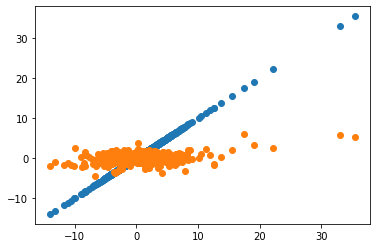

In [ ]:
# Returns on the tracking portfolio

Portfolio=df_eret
MKT=df_factor['Mkt-RF']
Tracking=MKT*beta

plt.scatter(x=Portfolio,y=Portfolio)
plt.scatter(x=Portfolio,y=Tracking)
plt.show()

We see here the obvious fact that we cannot track at all variation in HML with the market portfolio so the capture very different risks

**Hedged portfolio**

The Hedged strategy return (also called portable alpha) is 

 $$r^{hedged}_i=r^e_i-\beta_ir^{MKT}$$

 * This portfolio can be constructed simply by $W^i-\beta^iW^{MKT}$, the weights of the trading strategy minus the tracking portfolio weights. 
  
 * The excess returns take out risk-free rate effects, and the hedged portfolio takes out  factor effects

A few observations

- The mean return of the hedged portfolio is just the time series alpha!

- The volatility of the strategy is the vol of the residuals of the time series regression

- If you run a regression on the market you will see that the hedged portfolios have $\beta=0$, which is by design--you build the portfolio using the in sample beta, so it will hit zero on the nose in sample 

- This is the reason why sometimes people call these portfolios "Pure Alpha", or as Bridgwater calls it, "Portable Alpha"




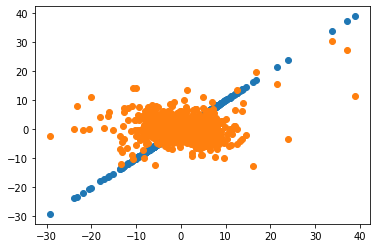

<AxesSubplot:xlabel='Date'>

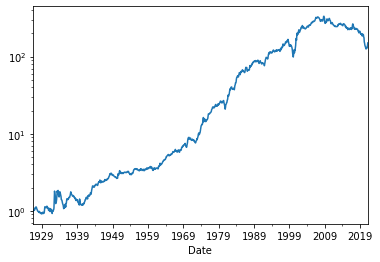

In [ ]:
# Returns on the hedged portfolio
Hedged=Portfolio-Tracking
RF=df.RF
plt.scatter(x=MKT,y=MKT)
plt.scatter(x=MKT,y=Hedged)
plt.show()
(Hedged/100+RF/100+1).cumprod().plot(logy=True)


>#### Insight

>The average excess return on the hedged portfolio is the alpha of the unhedged portfolio!
>Intuition: The hedged portfolio has mechanically zero beta (in-sample) so it's excess return is "pure" alpha.

In [ ]:

print('hedge portfolio excess returns')
print(Hedged.mean()*12)
print('alpha of unhedge portfolio')
print(alpha*12)


hedge portfolio excess returns
2.7509763704390657
alpha of unhedge portfolio
2.7509763704390675


## Variance Decomposition


  






Factor models are essential to manage risk

A pod shop mananager , a manager in a mutual fund in a large mutual fund company, a hedge fund trader in a large hedge fund,...all of those will typically have tight limits on the TOTAL risk of their portfolio, i.e. $var(r)$ but also on the factor component of their portfolio

But even if you don't, and you are an active manager with freedom of trading, you still want to control quite carefully how much non-essential risks you are taking in your portfolio

The decomposition here with single factor is really easy, but once you understand it, the multi-factor decomposition will be also easy to understand ( even it a little more involved)

1. The total variance of your strategy/asset is

$$Var(r^e)=Var(\alpha +b*f+\epsilon)=Var(b*f)+Var(\epsilon)=b^2Var(f)+var(\epsilon)$$

We can see already the factor part $(b^2Var(f))$ and the idiosyncratic part $var(\epsilon)$

2. The fraction of factor risk in your portfolio is

$$\frac{b^2Var(f)}{Var(r^e)}$$

You factor risk depends

- on your factor beta--this might grow in a market turmoil for example
- on the factor variance--also might grow when markets are choppy

The factor risk-share also depend on the idio vol. During a market turmoil all vols tend to go up, but factor vols tend to go up more
So both your total risk grows as the share of factor risk

In [79]:
beta**2*var_f/var_r

0.4141025460425463

Suppose I want to get this to the 20% limit. What do I do?

Lets say xh is your position on the market, then your portfolio is

$$rp=x(1*re+xh*f)$$

You want the factor piece to be less than vbar=20%

$$Var(rp)=Var(x(1*re+xh*f))=Var(x(1*(\alpha+\beta*f+\epsilon)+xh*f))=Var(x(\beta+xh)*f)+x^2Var(\epsilon)$$

$$Var(rp)=x^2(\beta+xh)^2*Var(f)+x^2Var(\epsilon)$$

so we need


$$\frac{x^2(\beta+xh)^2*Var(f)}{x^2(\beta+xh)^2*Var(f)+x^2Var(\epsilon)}=vbar$$

Note that your size of your overall portfolio cancels out. 

What matters for the share is your hedge per unit of position

$$\frac{(\beta+xh)^2*Var(f)}{(\beta+xh)^2*Var(f)+Var(\epsilon)}=vbar$$

reorganizing


$$(\beta+xh)^2*Var(f)=vbar*((\beta+xh)^2*Var(f)+Var(\epsilon))$$

$$(1-vbar)(\beta+xh)^2*Var(f)=vbar*Var(\epsilon)$$

$$(\beta+xh)^2=\frac{vbar*Var(\epsilon)}{(1-vbar)Var(f)}$$

$$(\beta+xh)=\sqrt{vbar\frac{Var(\epsilon)}{(1-vbar)Var(f)}}$$

$$xh=\sqrt{\frac{vbar*Var(\epsilon)}{(1-vbar)Var(f)}}-\beta$$



What is the hedge portfolio if you want zero factor risk?

In [80]:
vbar=0.2
xh20=((vbar*var_e)/((1-vbar)*var_f))**0.5-beta
xh20

-0.4816910986685352

## Factor models means you need to estimate LESS parameters



We will see how we can compute covariance matrixes easily under the assumption that the factor captures most sources of co-movement across stocks

In this case the assumption is very bad...and not even close to holding for most assets...but will allow us to get the intuition

We will then learn how to do it with many factors as is standard in the industry


Here I will use i,j for a individual stock


$$r^{e,i}=\alpha_i+\beta_{i,f}f+\epsilon_{i}$$

- non-factor component $\epsilon_i$ of the asset return of asset $i$. Assumed to uncorrelated between any two assets

Now this is just a regression!

We have that

$$Var(r^{e,i})=\beta_i^2Var(f)+var(\epsilon_{i})$$


This gives us a nice decomposition of risk as we saw above

- the risk component that is driven by the common factor
- the asset specific comment


Now if our assumption holds,i.e. the non-factor risk is uncorrelated across assets

 $$cov(\epsilon_{i,t},\epsilon_{j,t})=0$$


>#### This will never hold in any sample. It is an assumption that you impose after you think that you add enough factors to capture the  co-movement across assets
Then 

$$Cov(r_t^{e,i},r_t^{e,j})=Cov(\alpha_i+\beta_{i}f_t+\epsilon_{i,t},\alpha_j+\beta_{j}f_t+\epsilon_{j,t})=\beta_i\beta_jVar(f_t)$$

And the covariance matrix is simply


$$
\left[\begin{array}{cc}
\beta_i^2 & \beta_i\beta_j \\
\beta_i\beta_j &  \beta_j^2 
\end{array}\right]var(f_t)+\left[\begin{array}{cc}
var(\epsilon_{i,t}) & 0 \\
0&  var(\epsilon_{j,t})
\end{array}\right]$$

We see that now for N assets we only need to estimate N factor exposures, N asset specific volatilities , and the factor volatility

>$2N+1$ vs $(N^2-N)/2+N$


That is a huge difference!


 
>### Practice
> - Choose a five  tickers you like plus SPY
> - Estimate their unrestricted covariance matrix?
> - estimate the single-factor model (single factor=SPY) implied covariance matrix?
> - Can you compare the number of parameters you need to estimate in each case?
> - Can you discuss if it such model is a good one in this case? 
